## Loading Image Data with a Custom `Dataset`

In [80]:
import os 
import numpy as np
import wget
import matplotlib.pyplot as plt

from zipfile import ZipFile
from pathlib import Path
from datetime import datetime

import torch
import torchvision

from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import Tuple, Dict, List, Any

In [ ]:
# versions
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

# cuda version
print(f"Cuda version: {torch.version.cuda}")

# created date
print(f"Created date: 2023-08-17 10:55:41")

# modified date
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Modified date: {now}")

In [ ]:
DATA_DIR = Path('../data/')
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    
DATASET_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

DATASET_ZIPFILE_NAME = "pizza_steak_sushi.zip"
DATASET_FOLDER_NAME = "pizza_steak_sushi"

In [ ]:
DATASET_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_ZIPFILE_NAME)
DATASET_FOLDER_PATH = DATA_DIR.joinpath(DATASET_FOLDER_NAME)

In [ ]:
# download the dataset 
if DATASET_ZIPFILE_PATH.is_file():
    print(f"The {DATASET_ZIPFILE_NAME} already exists. Skipped downloading.")
else:
    print(f"The {DATASET_ZIPFILE_NAME} is downloading...")
    try:
        wget.download(url=DATASET_URL, out=str(DATA_DIR))
    except Exception as error:
        print(f"Caught this error {error}")

In [ ]:
# extract the dataset 
if DATASET_FOLDER_PATH.is_dir():
    print(f"The {DATASET_ZIPFILE_NAME} is already extracted. Skipped extracting.")
else: 
    print(f"The {DATASET_ZIPFILE_NAME} is extracting...") 
    try:
        zipper = ZipFile(DATASET_ZIPFILE_PATH)
        zipper.extractall(path=DATA_DIR)
        zipper.close()
    except Exception as error:
        print(f"Caught this error: {error}")

In [57]:
# train directory
train_dir = DATASET_FOLDER_PATH.joinpath("train")
if train_dir.is_dir():
    for filepaths, dirnames, filenames in os.walk(train_dir):
        if len(filenames) > 0:
            print(f"[TRAINING SET] - There are {len(filenames)} images in the {filepaths}")
else:
    print(f"Please make sure the {train_dir} exists")
    
# test directory 
test_dir = DATASET_FOLDER_PATH.joinpath("test")
if test_dir.is_dir():
    for filepaths, dirnames, filenames in os.walk(test_dir):
        if len(filenames) > 0:
            print(f"[TESTING SET] - There are {len(filenames)} images in the {filepaths}")
else:
    print(f"Please make sure the {test_dir} exists")

[TRAINING SET] - There are 78 images in the ../data/pizza_steak_sushi/train/pizza
[TRAINING SET] - There are 75 images in the ../data/pizza_steak_sushi/train/steak
[TRAINING SET] - There are 72 images in the ../data/pizza_steak_sushi/train/sushi
[TESTING SET] - There are 25 images in the ../data/pizza_steak_sushi/test/pizza
[TESTING SET] - There are 19 images in the ../data/pizza_steak_sushi/test/steak
[TESTING SET] - There are 31 images in the ../data/pizza_steak_sushi/test/sushi


#### 1. Using `default` ImageFolder

In [ ]:
# transform helper
transform_helper = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [38]:
# train_data
train_data = ImageFolder(root=train_dir, transform=transform_helper)

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [39]:
# test_data
test_data = ImageFolder(root=test_dir, transform=transform_helper)
test_data.classes, test_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [55]:
# list of paths 
file_paths = list(Path(test_dir).glob("*/*.jpg"))

In [62]:
# file_path, class_name
file_paths[0], file_paths[0].parent.name

(PosixPath('../data/pizza_steak_sushi/test/pizza/2871261.jpg'), 'pizza')

In [56]:
# check length
len(file_paths)

75

#### 2. Create `custom` ImageFolder

In [46]:
# class names
classes = [dir_entry.name for dir_entry in os.scandir(train_dir) if dir_entry.is_dir()]

# class to idx
class_to_idx = {class_name: idx for idx, class_name in enumerate(classes) }
classes, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [98]:
class CustomImageFolder(Dataset):
    def __init__(self, root: str, transform: None) -> None:
        super().__init__()

        self.file_paths = list(Path(root).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = self.find_classes(directory=root)

    def find_classes(self, directory: str):
        
        if Path(directory).is_dir():
        
            # class names
            classes = [dir_entry.name for dir_entry in os.scandir(train_dir) if dir_entry.is_dir()]

            # class to idx
            class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

        else:
            raise FileNotFoundError(f"Couldn't find the {directory}")
        
        return classes, class_to_idx
    
    def load_image(self, file_path: str):
        if Path(file_path).is_file():
            image = Image.open(file_path)
        else:
            raise FileNotFoundError(f"Couldn't find the {file_path}")
        return image

    def __len__(self) -> int:
        return len(self.file_paths)
    
    def __getitem__(self, index) -> Tuple[Any, int]:
        
        image = self.load_image(self.file_paths[index])
        file_path = self.file_paths[index]
        class_name = file_path.parent.name
        class_idx = None

        if class_name in self.classes:
            class_idx = self.class_to_idx[class_name]
        else:
            raise ValueError(f"Couldn't find the {class_name} in {self.classes}")

        if self.transform:
            image = self.transform(image)

        return image, class_idx

In [99]:
# transform helper
transform_helper = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [100]:
# train_data
train_data_custom = CustomImageFolder(root=train_dir, transform=transform_helper)

train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [101]:
# test_data
test_data_custom = CustomImageFolder(root=test_dir, transform=transform_helper)
test_data_custom.classes, test_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [102]:
train_data_custom

In [103]:
test_data_custom

In [104]:
# check for equality amongst CustomImageFolder Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [105]:
# dataloader
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=1, num_workers=0, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=1, num_workers=0, shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f88b10fa340>,
 <torch.utils.data.dataloader.DataLoader at 0x7f88b14e4eb0>)

In [107]:
# one batch
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom

(torch.Size([1, 3, 224, 224]), tensor([0]))

Text(0.5, 1.0, 'pizza')

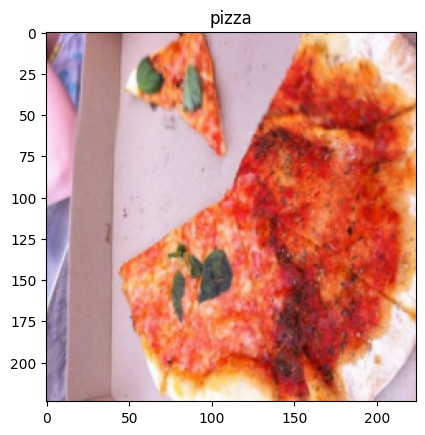

In [114]:
# display img_custom
plt.imshow(img_custom.squeeze().permute(2,1,0))
plt.title(f"{classes[label_custom]}")